In [1]:
import pyam
import pandas as pd
from scipy.stats import pearsonr

from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns

<IPython.core.display.Javascript object>

Step 1: Read in the data

In [2]:
df = pyam.IamDataFrame(
    Path(
        '../data/101_data.xlsx'
    )
)

pyam - INFO: Running in a notebook, setting up a basic logging at level INFO
pyam.core - INFO: Reading file ../data/101_data.xlsx
pyam.core - INFO: Reading meta indicators


Step 2: Filter for the C1 and C2 scenarios, which are the categories assessed by Prütz et al,

In [3]:
df_c1_c2 = (
    df
    .filter(
        Category=[
            'C1',
            'C2'
        ],
        region='World'
    )
)

Step 3: We need to know how many scenarios we will assess. The original paper estimates the results for 83.

In [4]:
len(df_c1_c2.meta)

176

In [5]:
df_c1_c2.variable

['AR6 Reanalysis|OSCARv3.2|Carbon Removal',
 'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Land',
 'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Land|Direct',
 'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Land|Indirect',
 'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Non-Land',
 'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Total',
 'AR6 Reanalysis|OSCARv3.2|Emissions|CO2',
 'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|AFOLU',
 'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|AFOLU|Direct',
 'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|AFOLU|Indirect',
 'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|Direct Only',
 'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|Gross',
 'AR6 Reanalysis|OSCARv3.2|Emissions|Kyoto Gases',
 'AR6 Reanalysis|OSCARv3.2|Emissions|Kyoto Gases|Direct Only',
 'AR6 climate diagnostics|Infilled|Emissions|CH4']

Step 4: We need the total (direct) carbon removal in 2050 and 2100.

In [6]:
variable_cdr = 'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Total'

In [7]:
for t in [2030, 2050, 2100]:
    df_c1_c2.set_meta_from_data(
        name=f'cdr_{t}',
        variable=variable_cdr,
        year=t
    )
    
    df_c1_c2.set_meta_from_data(
        name=f'land_cdr_{t}',
        variable='AR6 Reanalysis|OSCARv3.2|Carbon Removal|Land|Direct',
        year=t
    )

    df_c1_c2.set_meta_from_data(
        name=f'novel_cdr_{t}',
        variable='AR6 Reanalysis|OSCARv3.2|Carbon Removal|Non-Land',
        year=t
    )
    

Step 5: We need the cumulative CDR between 2020 and 2100.

In [8]:
cdr = (
    df_c1_c2
    .filter(
        variable=variable_cdr
    )
    .timeseries()
)

In [9]:
df_c1_c2.set_meta(
    cdr.apply(
        lambda x: pyam.cumulative(
            x,
            first_year=2020,
            last_year=2100
        ),
        axis=1
    ),
    name='cdr_2020_2100'
)

Step 6: We need to assign the net CO2 emissions in 2030.

In [10]:
net_emission_variable = 'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|Direct Only'

In [11]:
df_c1_c2.set_meta_from_data(
    name='net_co2_2030',
    variable=net_emission_variable,
    year=2030
)

Step 7: We now need to estimate the non-CO2 emissions in 2050.

In [12]:
df_c1_c2.subtract(
    a='AR6 Reanalysis|OSCARv3.2|Emissions|Kyoto Gases|Direct Only',
    b=net_emission_variable,
    name='Emissions|Non-CO2',
    ignore_units='Gt CO2-equiv/yr',
    append=True
)

In [13]:
df_c1_c2.set_meta_from_data(
    name='non_co2_2050',
    variable='Emissions|Non-CO2',
    year=2050
)

Step 8: We need the non-CO2 emissions at net zero.

In [14]:
netzero_year = 'Interpolated Net-Zero Year for AR6 Reanalysis|OSCARv3.2|Emissions|CO2|Direct Only'

In [15]:
non_co2_ts = (
    df_c1_c2
    .filter(
        variable='Emissions|Non-CO2'
    )
    .timeseries()
)

In [16]:
df_c1_c2.set_meta(
    non_co2_ts.apply(
        lambda x: pyam.cumulative(
            x,
            first_year=df_c1_c2.meta.loc[x.name[0:2], netzero_year],
            last_year=df_c1_c2.meta.loc[x.name[0:2], netzero_year]
        ),
        axis=1
    ),
    name='non_co2_netzero'
)

Step 9: Gross CO2 emissions in 2050

In [17]:
gross_co2_variable = 'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|Gross'

In [18]:
df_c1_c2.set_meta_from_data(
    name='gross_co2_2050',
    variable=gross_co2_variable,
    year=2050
)

Step 10: Gross CO2 emissions at net zero.

In [19]:
gross_co2_ts = (
    df_c1_c2
    .filter(
        variable=gross_co2_variable
    )
    .timeseries()
)

In [20]:
df_c1_c2.set_meta(
    gross_co2_ts.apply(
        lambda x: pyam.cumulative(
            x,
            first_year=df_c1_c2.meta.loc[x.name[0:2], netzero_year],
            last_year=df_c1_c2.meta.loc[x.name[0:2], netzero_year]
        ),
        axis=1
    ),
    name='gross_co2_netzero'
)

Step 11: Warming reversal after peak

In [21]:
df_c1_c2.meta.loc[:, 'warming_reversal'] = (
    df_c1_c2.meta.loc[:, 'Median peak warming (MAGICCv7.5.3)']
    -
    df_c1_c2.meta.loc[:, 'Median warming in 2100 (MAGICCv7.5.3)']
)

Step 12: Exceedance probabiliy of 1.5C

In [22]:
df_c1_c2.meta.loc[:, 'exceedance_1p5'] = df_c1_c2.meta.loc[:, 'Exceedance Probability 1.5C (MAGICCv7.5.3)']

Step 13: Timing of net zero CO2 emissions.

In [23]:
df_c1_c2.meta.loc[:, 'net_zero_year'] = df_c1_c2.meta.loc[:, netzero_year]

Step 14: Define sets of columns

In [24]:
y_cols = [
    'land_cdr_2030',
    'land_cdr_2050',
    'land_cdr_2100',
    'novel_cdr_2030',
    'novel_cdr_2050',
    'novel_cdr_2100',
    'cdr_2050',
    'cdr_2100',
    'cdr_2020_2100'
]

In [25]:
x_cols = [
    'net_co2_2030',
    'non_co2_2050',
    'non_co2_netzero',
    'gross_co2_2050',
    'gross_co2_netzero',
    'warming_reversal',
    'exceedance_1p5',
    'net_zero_year'
]

Step 15: Run through and assign the pearsons values to a dataframe. Then plot out a heatmap with seaborn.

In [26]:
df = pd.DataFrame()
for x in x_cols:
    for y in y_cols:
        df.loc[y,x] = pearsonr(
            x=df_c1_c2.meta.loc[:, x].values,
            y=df_c1_c2.meta.loc[:,y].values
        ).statistic.round(2)

Step 16: Start with the global characteristics

[Text(0.5, 0, 'Net CO$_2$ emissions\n2030'),
 Text(1.5, 0, 'Non-CO$_2$ emissions\n2050'),
 Text(2.5, 0, 'Non-CO$_2$ emissions\n net zero'),
 Text(3.5, 0, 'Gross CO$_2$ emissions\n2050'),
 Text(4.5, 0, 'Gross CO$_2$ emissions\nnet zero'),
 Text(5.5, 0, 'Warming reversal\nmedian'),
 Text(6.5, 0, 'Peak exceedance\n1.5°C'),
 Text(7.5, 0, 'Net zero CO$_2$ year')]

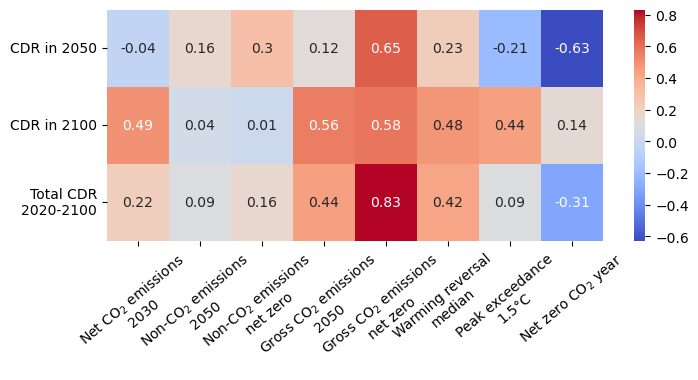

In [27]:
fig, ax = plt.subplots(
    figsize=(
        8, 3
    )
)

# Plot the correlation
glob_cols = [
    'cdr_2050',
    'cdr_2100',
    'cdr_2020_2100'
]

sns.heatmap(
    df.loc[glob_cols, :],
    cmap='coolwarm',
    ax=ax,
    annot=True
)

ax.set_yticklabels(
    [
        'CDR in 2050',
        'CDR in 2100',
        'Total CDR\n2020-2100'
    ]
)

ax.set_xticklabels(
    [
        'Net CO$_2$ emissions\n2030',
        'Non-CO$_2$ emissions\n2050',
        'Non-CO$_2$ emissions\n net zero',
        'Gross CO$_2$ emissions\n2050',
        'Gross CO$_2$ emissions\nnet zero',
        'Warming reversal\nmedian',
        'Peak exceedance\n1.5°C',
        'Net zero CO$_2$ year'
    ],
    rotation=40
)

In [28]:
fig.savefig(
    Path(
        'figures/SI_fig1.png'
    ),
    dpi=600,
    bbox_inches='tight'
)

Step 17: Conceptually linked land and novel CDR correlations

[Text(0.5, 0, 'Net CO$_2$ emissions\n2030'),
 Text(1.5, 0, 'Non-CO$_2$ emissions\n2050'),
 Text(2.5, 0, 'Non-CO$_2$ emissions\n net zero'),
 Text(3.5, 0, 'Gross CO$_2$ emissions\n2050'),
 Text(4.5, 0, 'Gross CO$_2$ emissions\nnet zero'),
 Text(5.5, 0, 'Warming reversal\nmedian'),
 Text(6.5, 0, 'Peak exceedance\n1.5°C'),
 Text(7.5, 0, 'Net zero CO$_2$ year')]

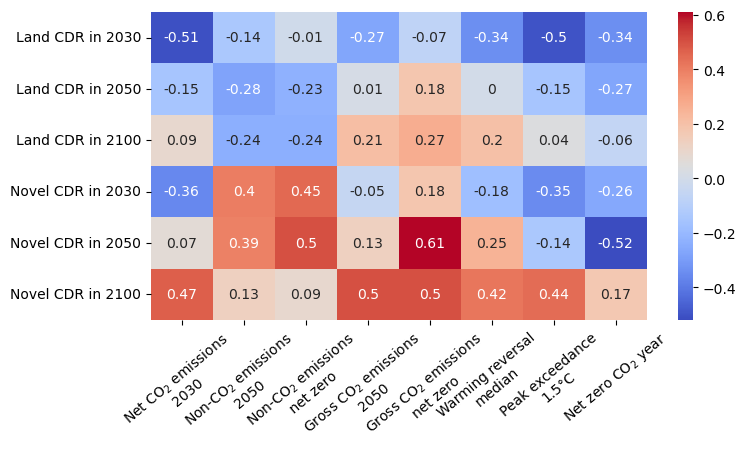

In [29]:
fig, ax = plt.subplots(
    figsize=(
        8, 4
    )
)

# Plot the correlation
other_cols = [
    'land_cdr_2030',
    'land_cdr_2050',
    'land_cdr_2100',
    'novel_cdr_2030',
    'novel_cdr_2050',
    'novel_cdr_2100'
]

sns.heatmap(
    df.loc[other_cols, :],
    cmap='coolwarm',
    ax=ax,
    annot=True
)

ax.set_yticklabels(
    [
        'Land CDR in 2030',
        'Land CDR in 2050',
        'Land CDR in 2100',
        'Novel CDR in 2030',
        'Novel CDR in 2050',
        'Novel CDR in 2100'
    ]
)

ax.set_xticklabels(
    [
        'Net CO$_2$ emissions\n2030',
        'Non-CO$_2$ emissions\n2050',
        'Non-CO$_2$ emissions\n net zero',
        'Gross CO$_2$ emissions\n2050',
        'Gross CO$_2$ emissions\nnet zero',
        'Warming reversal\nmedian',
        'Peak exceedance\n1.5°C',
        'Net zero CO$_2$ year'
    ],
    rotation=40
)

In [30]:
fig.savefig(
    Path(
        'figures/SI_fig2.png'
    ),
    dpi=600,
    bbox_inches='tight'
)